## A/B tests.

### Анализ результатов эксперимента по добавлению нового алгоритма рекомендации постов

Эксперимент проходил **с 2021-11-15 по 2021-11-21 включительно**. 
Для эксперимента были задействованы **1 и 2 группы**.

- **Группа 1**: контрольная группа без изменений.
- **Группа 2**: использовался новый алгоритм рекомендации постов.


### Гипотеза
**Новый алгоритм во 2-й группе приведет к увеличению CTR**.

### Задачи анализа
1. Применить различные статистические тесты:
   - t-тест
   - тест Манна-Уитни
   - t-тест на сглаженном CTR (α=5)
   - Пуассоновский бутстреп
   - t-тест или тест Манна-Уитни поверх бакетного преобразования
2. Визуализировать распределения данных и оценить их.
3. Сделать выводы и обосновать решения

In [16]:
import pandas as pd
from clickhouse_driver import Client
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import swifter
import pingouin as pg

db = 'simulator'
connection = Client(host='clickhouse.lab.karpov.courses',
                database=db,
                user='student',
                password='dpo_python_2020')

query = f'''
SELECT exp_group, 
    user_id, 
    sum(action='like') as likes,
    sum(action='view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) BETWEEN '2021-11-15' AND '2021-11-21' and exp_group in (1,2)
GROUP BY exp_group, user_id
'''
main_df = pd.DataFrame(connection.execute(query), columns=['exp_group', 'user_id','likes', 'views', 'ctr'])
main_df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,33,122,0.270492


In [17]:
#Проверяем размерность групп
main_df.groupby('exp_group')['user_id'].nunique().reset_index()

,exp_group,user_id
0,1,10079
1,2,9952


<Axes: xlabel='ctr', ylabel='Count'>

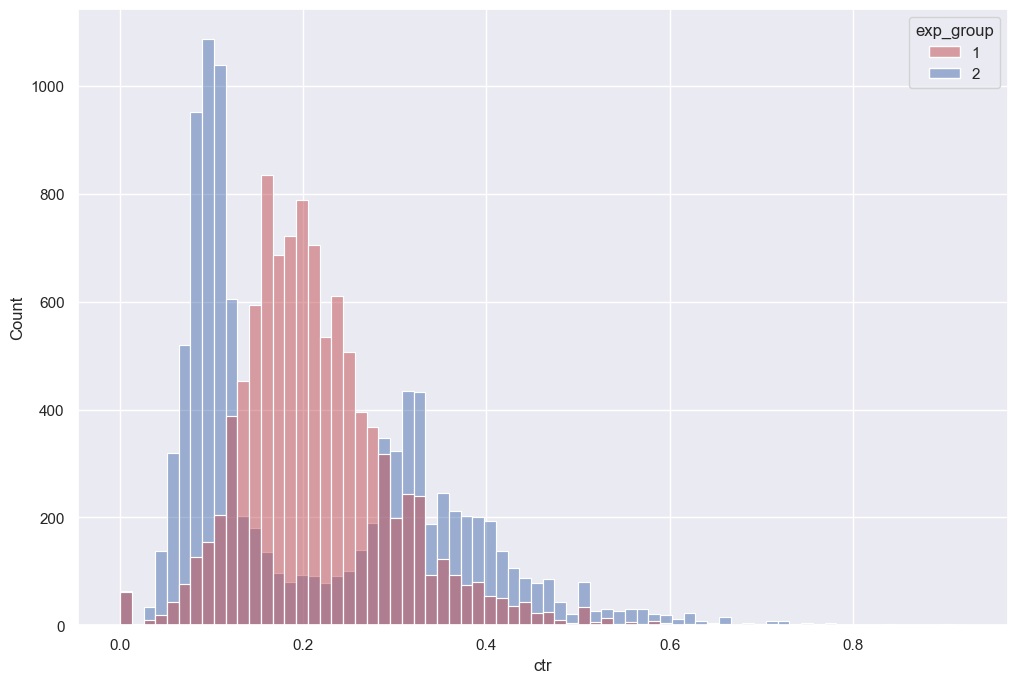

In [32]:
#Проверяем распределение CTR в группах
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=main_df, x='ctr', hue='exp_group', palette=['r','b'], alpha=0.5, kde=False)

### Анализ нормальности данных

In [21]:
#Проверим нормальность
pg.normality(data=main_df, dv='ctr', group='exp_group', method='normaltest')

,W,pval,normal
exp_group,,,
1,1828.33115,0.000000e+00,False
2,895.50335,3.498794e-195,False


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

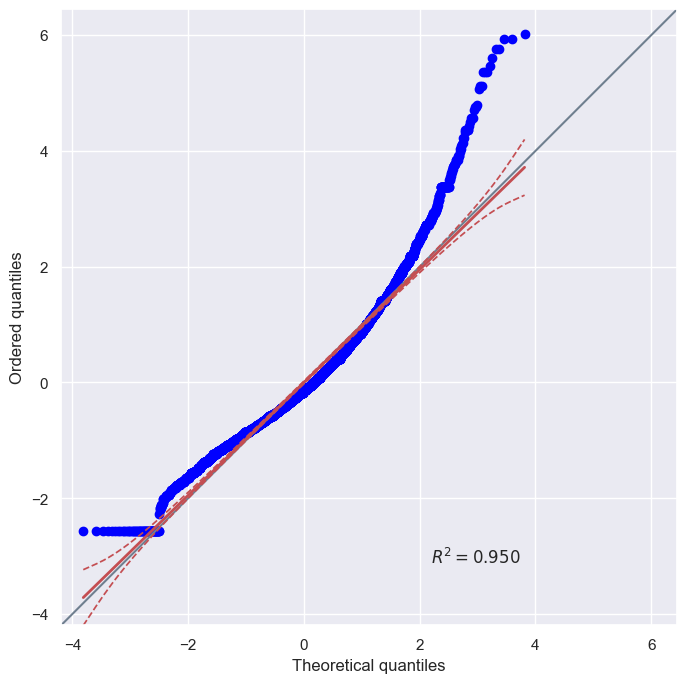

In [29]:
pg.qqplot(main_df[main_df.exp_group == 1].ctr)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

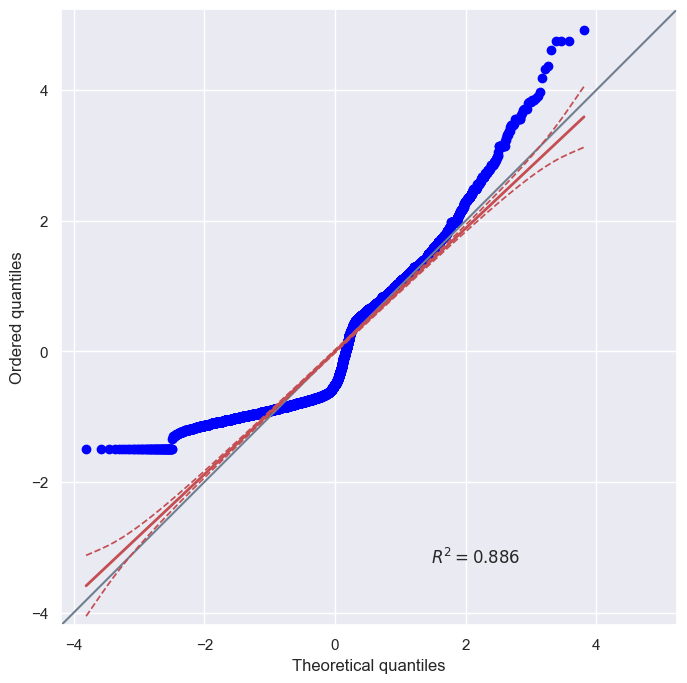

In [28]:
pg.qqplot(main_df[main_df.exp_group == 2].ctr)

<Axes: xlabel='exp_group', ylabel='ctr'>

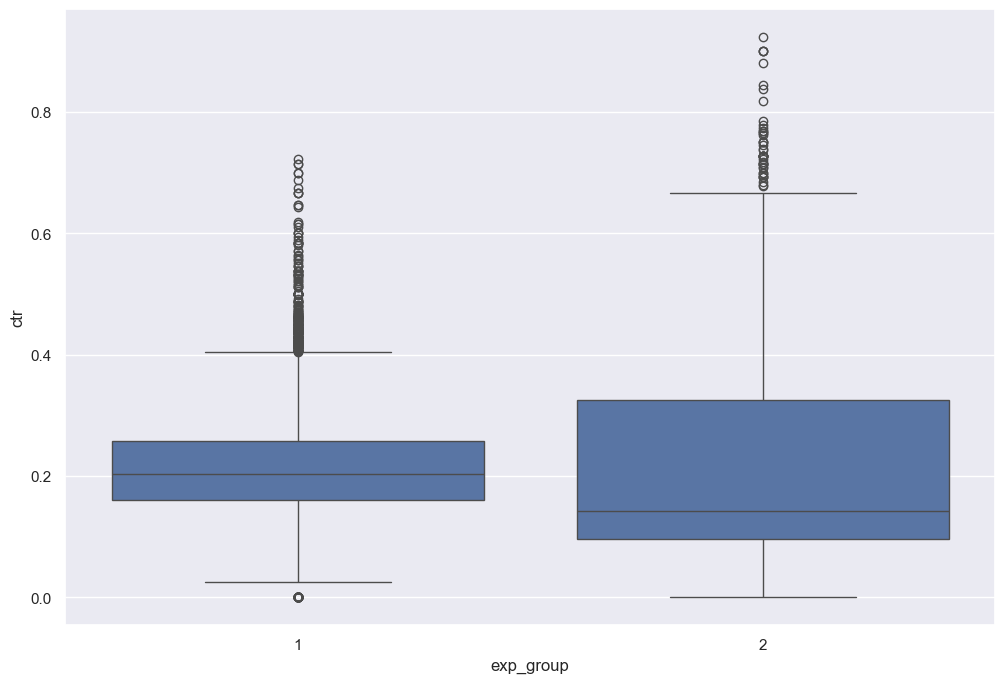

In [31]:
sns.boxplot(data = main_df, x = 'exp_group', y='ctr')

**Данные не являются нормальными**. Также в данных наблюдаются выбросы, поэтому следует применить различные методы для оценки эксперимента**.

### Проведем t-тест
- **Нулевая гипотеза (H₀)**: Средние значения двух групп одинаковы.

- **Альтернативная гипотеза (H₁)**: Средние значения двух групп различаются.

In [19]:
stats.ttest_ind(main_df[main_df.exp_group == 1].ctr,
               main_df[main_df.exp_group == 2].ctr,
               equal_var=False)

TtestResult(statistic=np.float64(0.709439204127032), pvalue=np.float64(0.47806231308750413), df=np.float64(15986.264286869278))

### Вывод по t-тесту
- **Мы не можем отвергнуть нулевую гипотезу**, так как **p-value больше уровня значимости** (α = 0.05).  
- Так как **данные не соответствуют критериям нормальности**, целесообразно рассмотреть **альтернативные методы анализа A/B-теста**.


### Проведем тест Манна-Уитни
- **Нулевая гипотеза (H₀)**: Распределения в двух группах идентичны.

- **Альтернативная гипотеза (H₁)**: Распределения в двух группах различаются.

In [36]:
stats.mannwhitneyu(main_df[main_df.exp_group == 1].ctr,
               main_df[main_df.exp_group == 2].ctr,
                  alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(56601260.5), pvalue=np.float64(6.0376484617779035e-56))

### Вывод по тесту Манна-Уитни
**Нулевая гипотеза отвергается**, так как непараметрический тест Манна-Уитни показал статистически значимые различия между выборками.

### Сглаженный CTR

Основная сложность применения t-теста к пользовательскому CTR заключается в высокой вариативности значений при малом числе просмотров. Если у пользователя всего 3 просмотра, его CTR будет крайне нестабильным, независимо от количества кликов. При 20 просмотрах метрика становится более информативной, а при 200 — уже достаточно точно отражает реальное поведение пользователя.

In [47]:
# функция для расчета сглаженного ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr
    
# расчитаем общий ctr для групп пользователей
global_ctr_1 = main_df[main_df.exp_group == 1].likes.sum()/main_df[main_df.exp_group == 1].views.sum()
global_ctr_2 = main_df[main_df.exp_group == 2].likes.sum()/main_df[main_df.exp_group == 2].views.sum()

group1 = main_df[main_df.exp_group == 1].copy()
group2 = main_df[main_df.exp_group == 2].copy()

group1['smothed_ctr'] = main_df.apply(
    lambda x: get_smother_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = main_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

TtestResult(statistic=np.float64(2.2841320431616983), pvalue=np.float64(0.022376981555855876), df=np.float64(15791.866890424124))

**Вывод:** применив t-test к сглаженному CTR мы получаем статистически значимые отличия и **отклоняем нулевую гипотезу** о равенстве средних

### Пуассоновский бутстреп для подсчета разницы в CTR

<Axes: ylabel='Count'>

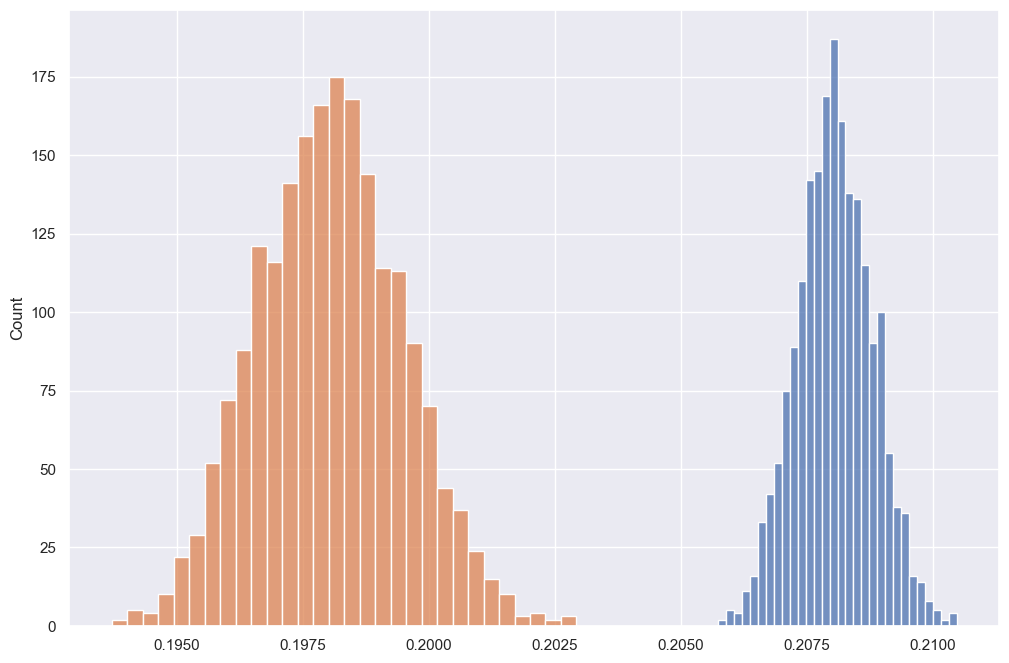

In [48]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstrap1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstrap2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)

    globalCTR1 = (poisson_bootstrap1 * likes1).sum(axis=1) / (poisson_bootstrap1 * views1).sum(axis=1)
    globalCTR2 = (poisson_bootstrap2 * likes2).sum(axis=1) / (poisson_bootstrap2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2


likes1 = main_df[main_df.exp_group == 1].likes.to_numpy()
views1 = main_df[main_df.exp_group == 1].views.to_numpy()
likes2 = main_df[main_df.exp_group == 2].likes.to_numpy()
views2 = main_df[main_df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

Text(0.5, 1.0, 'Гистограмма разницы между глобальными CTR')

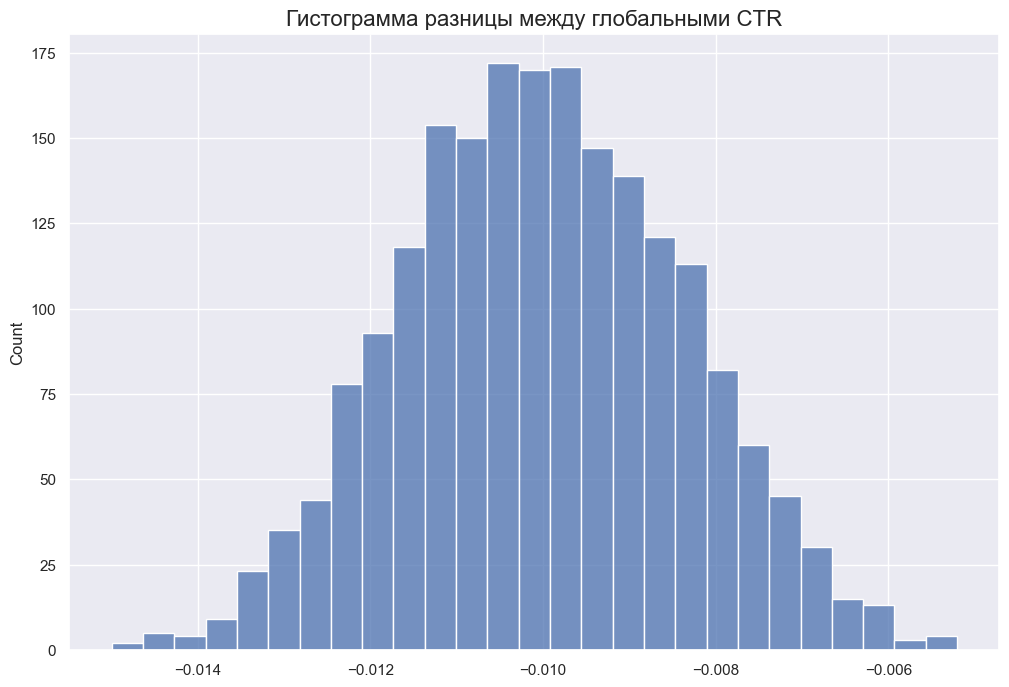

In [49]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)
plt.title('Гистограмма разницы между глобальными CTR', fontsize=16)

**Вывод**

Анализ гистограммы разности CTR между группами показывает, что значения не пересекают ноль, что говорит о существенном различии между 1 (контрольной) и 2 (тестовой) группами. Поскольку разность оказалась отрицательной, это указывает на более высокий CTR в контрольной группе по сравнению с тестируемой.

### Бакетное преобразование

In [50]:
# Напишем новый запрос в ClickHouse. Выведем группу, в которой состоит пользователь, его бакет, а также найдем bucket_ctr и CTR 90% квантиля
q = f'''
SELECT exp_group, bucket,
    sum(likes) / sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id, 
        sum(action='like') as likes,
        sum(action='view') as views,
        likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2021-11-15' AND '2021-11-21' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
'''
bucket_df = pd.DataFrame(connection.execute(q), columns=['exp_group', 'bucket', 'bucket_ctr', 'ctr9'])
bucket_df.head()

Error on clickhouse.lab.karpov.courses:9000 ping: timed out
Connection was closed, reconnecting.


,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


In [51]:
#Проверим нормальность распределения
pg.normality(data=bucket_df, dv='bucket_ctr', group='exp_group', method='normaltest')

,W,pval,normal
exp_group,,,
1,0.179266,0.914267,True
2,3.068258,0.215643,True


In [53]:
#Распределение нормальное, проведем t-test
stats.ttest_ind(bucket_df[bucket_df.exp_group == 1].bucket_ctr,
               bucket_df[bucket_df.exp_group == 2].bucket_ctr,
               equal_var=False)

TtestResult(statistic=np.float64(5.668234732054008), pvalue=np.float64(3.4455951649941936e-07), df=np.float64(65.9433101831566))

**Вывод:** При проведении t-теста на бакетных CTR, тест увидел отличия.

### Проведем тесты для 90%-го квантиля CTR

In [55]:
#Проверим нормальность распределения ctr 90% квантиля
pg.normality(data=bucket_df, dv='ctr9', group='exp_group', method='normaltest')

,W,pval,normal
exp_group,,,
1,1.702798,0.426817,True
2,6.386009,0.041048,False


Вторая группа не имеет нормального распределения, поэтому, для уверенности, воспользуемся тестом Манна-Уитни, чтобы выявить различия 90% квантиля в двух группах 

In [56]:
stats.mannwhitneyu(bucket_df[bucket_df.exp_group == 1].ctr9,
               bucket_df[bucket_df.exp_group == 2].ctr9,
               alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(6.344839189967265e-18))

Тест Манна-Уитни **показал статистически значимые отличия**, что подтверждает альтернативную гипотезу о различии в распределениях двух групп.

### Общий вывод

На основании проведенных тестов, можно сделать вывод, что контрольная и тестовые группы **статистически значимо различаются.** Исходя из полученных данных, **запуск нового алгоритма для всех пользователей в его текущем виде не рекомендуется**. Поскольку наша цель заключалась в повышении CTR, а результаты анализа указывают на его снижение.







